# sivtempfit generative model development

Ruffin Evans

2016-04-10

This notebook develops the generative model that will eventually be used to fit the spectra data in this package.

I'll do this in two steps.

First, I'll write down the generative model. The end result of this section will be to produce a spectrum that "looks like" the spectra produced experimentally depending on the parameters.

Next, given this generative model, I will write down the likelihood function which expresses how well the data agrees with the model (literally, the likelihood that the data is drawn from the model.) The main part that is hard about this is that I need to make a statement about the uncertanties in the data.

## Standard Imports

In [41]:
# makes plots display inline in notebook interface:
%matplotlib inline 

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
import emcee
import pandas as pd
import seaborn as sns
import scipy.stats as stats # Use for KDE in the end
import scipy.optimize as opt # Use for minimizing KDE
import scipy as sp
sns.set_style("whitegrid")

## Generative Model

The model that I'll start with is fairly simple. It contains two peaks: one for the laser line, and one for the SiV itself.

Some preliminary fitting suggests that both peaks are very well fit by a Lorentzian and not by a Gaussian. Physically, it's not clear what the situation should be. For a single SiV, the spectrum should be Lorentzian, but we generally measure an ensemble of SiVs with enough of an inhomogeneous distribution that there could be a Gaussian component.

In the future, therefore, I may upgrade this model to fit a [Voigt profile](http://scipython.com/book/chapter-8-scipy/examples/the-voigt-profile/) to these lines instead. But this is possibly computationally more expensive (both in terms of evaluating the function and in terms of the added parameters) so let's just stick with the two-lorentzian model for now.

### A word about resolution

Vinny suggested that I include in my model some "blur" from the spectrometer itself. This effects the two peaks in the spectrum in two separate ways.

The laser line is intrinsically much narrower ($\lesssim 100 \mathrm{MHz}$) than the resolution of the spectrometer ($\sim10\mathrm{GHz}$). Hence, the laser line is only limited by the resolution of the spectrometer, and blurring this line would be accounting for this effect twice.

The SiV line is intrinsically much broader ($\sim2\mathrm{THz}$) than the resolution of the spectrometer, so the effect of the spectrometer resolution will be minimal.

Finally, if both lines are indeed lorentzians, then that means the transfer function of the spectrometer is a lorentzian. Since the siv line is lorentzian by assumption, and the convolution of two lorentzians is a lorentzian, fitting a single lorentzian is actually general in this case.

Motivated by these considerations, I will not introduce a specific blurring from the spectrometer for now.

### Construction of the model

The model here has two Lorentzian peaks plus a constant background. The peaks have arbitrary amplitude and width (although we have strong priors on the width on the narrower (laser) peak).

We'll parameterize the center positions of the peak with two variables: $C_2$ and $C_2-C_1$. This choice is motivated by the desire to use the laser peak with center $C_2$ as a calibration, so $C_1-C_2+\lambda_2$ is the actual center position of peak 1 independent of the wavelength calibration of the instrument since $\lambda_2$ is known exactly.

In the future, we will test a model for the temperature dependence of $C_1$ which we expect to be approximately linear over a suitable range. Anticipating this, we will write $C_1 = T\times m$ where $m = \frac{d\lambda}{dT}$. We'll have to change this formulation slightly to test higher order models for the temperature scaling.

First, define a standard Lorentzian. This could be done by using scipy.stats.cauchy.pdf , but I'm not sure if that is efficient.

In [42]:
def lorentz(x, center, width):
    """
    A lorentzian function with peak position 'center' and FWHM 'width'.
    """
    return (1/np.pi)*(width/2)/((x-center)**2+(width/2)**2)

Now, we can define the model

In [43]:
def two_peak_model(x, amp1, amp2, center_offset, center2, width1, width2, background):
    return background + amp1*lorentz(x, center_offset + center2, width1) + amp2*lorentz(x, center2, width2)

For example, we expect the spectra to look something like this:

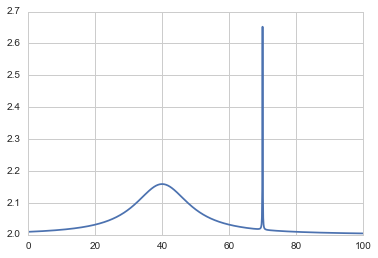

In [44]:
xrange = np.arange(0,100,0.1)
plt.plot(xrange, two_peak_model(xrange, 5, 0.1, -30, 70, 20, 0.1, 2))

## Likelihood

As noted above, this requires us to make statements about the noise in our system. We have characterized our system a bit and the noise seems to be primarily limited by shot noise. 

There are some subleties here, however. The shot noise is only on the photons that are actually detected, whereas there is also a readout noise on the detector of "three electrons" (according to the datasheet) per bin. Absent any other information, I assume this is gaussian noise. Moreover, the detector itself contributes a more or less fixed background (of around 1000 counts) on top of this noise. So, we'll include an additional term in the likelihood that includes this fixed CCD readout background plus associated noise.

The likelihood is then the product of two terms: one is a Gaussian likelihood for the CCD background, and one is a Poisson likelihood for the actual photon signal. In each of these two terms, we subtract the contribution to the signal from the other term before we calculate that contribution to the likelihood. In other words, for the CCD background, we take the signal, subtract what we think is coming from the light entering the instrument --- which is the two_peak_model --- and then consider Gaussian noise on that residual bit. For the poisson noise, we subtract the CCD offset from the signal before we fit the poisson noise.

I am not sure if this is the correct thing to do, because it means that if there is gaussian noise on the CCD, it still reduces the likelihood for the poisson contribution because we are subtracting only the background and not any noise. I will try to figure out if this is legit.

Here, we will also switch to the (for now, redundant) parameterization in terms of $T$ and $m$, plus an offset $C_0$. For fitting a single spectrum, $T$ can be set to zero and the fit will be in terms of $C_0$ only.

In [45]:
def two_peak_log_likelihood(y, x, amp1, amp2, T, m, C0, center2, width1, width2, light_background, ccd_background, ccd_stdev):
    """
    Returns the log-likelihood calculated for the two-peak + CCD noise model.
    See also: two_peak_model
    
    Parameters:
    -----------
    y : observed data value
    x : corresponding wavelength or x-axis value
    amp1 : amplitude of the broad SiV peak in the spectrum
    amp2 : amplitude of the narrow calibration peak in the spectrum
    T : The temperature of the sample
    m : The linear scaling of the SiV peak position with temperature
    C0 : The offset in the above linear scaling
    center2 : The position of the calibration line
    width1 : The width (FWHM) of the SiV line
    width2 : The width (FWHM) of the calibration line
    light_background : The contribution to the background from stray light,
                       contributing shot noise
    ccd_backgrond : The contribution to the background from CCD readout,
                    contributing gaussian noise
    ccd_stdev : The standard deviation on the gaussian CCD noise above
    """
    # First, get the contribution from the light signal.
    y_two_peak_model = two_peak_model(x, amp1, amp2, C0 + T*m - center2, center2, width1, width2, light_background)
    # Calculate the contribution from the gaussian term
    # To do this, subtract the prediction from the two-peak model to compare
    # the predicted background ccd_background to the residuals from the
    # two_peak_model. 
    likelihood_gauss = 1/(np.sqrt(2*np.pi*ccd_stdev**2))*np.exp(-1*(y - y_two_peak_model - ccd_background)**2/(2*ccd_stdev**2))
    # Calculate the contribution from the poissonian term. Here, we subtract
    # the ccd_background contribution so that we're only looking at shot-noise
    # on the part of the signal that does not come from the ccd background
    likehood_poisson = y_two_peak_model**(y-ccd_background)/sp.misc.factorial(y-ccd_background)*np.exp(-y_two_peak_model)
    # Retrn the log-likelihood
    return np.sum(np.log(likelihood_gauss) + np.log(likelihood_poisson))